In [1]:
import os
import time
from collections import defaultdict
from itertools import chain

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics import roc_auc_score

# Pipeline

### Data Loader

We need to load networks into memory. Usually networks are organized as pairs of nodes. And sometimes different edges have different weights. Hence, we use networkx.DiGraph to store such structure information and attributes.

In [2]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)

    return edges


def load_test_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append((row["src"], row["dst"]))
    edges = sorted(edges)

    return edges


def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges)
    print(N, len(true_edges))
    false_edges = set()

    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)]
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)

    return false_edges


def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))

    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)

    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())

    return graph

### Random Walk Generator

Random walk generators or random walkers yield random walks that contain both local and higher-order neighborhood information. However, naive non-uniform sampling is very slow, which requires O(n) time complexity. Here alias sampling can reduce the time complexity to O(1) with O(n) space. If you are interested, please see the following blog.

In [3]:
def alias_setup(probs):
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = list()
    larger = list()
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q


def get_alias_node(graph, node):
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]["weight"])
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)


def get_alias_edge(graph, src, dst, p=1, q=1):
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src:  # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"] / p)
        elif graph.has_edge(dst_nbr, src):  # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"])
        else:  # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"] / q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)


def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges

The difference between DeepWalk and node2vec is how to generate random walks. The former only consider the first-order information while the latter also involves the second-order information.

In [4]:
def alias_draw(J, q):
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


# helper function to generate the long random walk as desired
def fallback(walk, fetch_last_num=1):
    if len(walk) > fetch_last_num:
        walk.pop()
        fetched = []
        for i in range(fetch_last_num):
            fetched.append(walk[-1 - i])
        return walk, fetched
    else:
        return [], [None for _ in range(fetch_last_num)]


def generate_first_order_random_walk(graph, alias_nodes,
                                     walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the first order information.
    max_trials: set the max trials to be one for standard random walk. Larger max_trails will make the generated biased.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:  # if we can sample next nodes
            # sample the next node based on alias_nodes
            cur = cur_nbrs[alias_draw(*alias_nodes[cur])]
            walk.append(cur)
        else:  # if we can't do that
            num_tried += 1
            if num_tried >= max_trails:
                break

            walk, fetched = fallback(walk, fetch_last_num=1)
            cur = fetched[0]
            if len(walk) == 0:  # if falls back to the empty walk
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
    ########## end ##########

    if verbose:
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk


def generate_second_order_random_walk(graph, alias_nodes, alias_edges,
                                      walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]

    prev = None
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])]
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            num_tried += 1
            if num_tried >= max_trails:
                break
            walk, (cur, prev) = fallback(walk, fetch_last_num=2)
            if len(walk) == 0:
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
                prev = None
    ########## end ##########
    if verbose:
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

### Network Embedding Algorithms

In [5]:
def build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10):
    """
    build a deepwalk model
    """
    print("building a DeepWalk model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))

    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")

    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    print("training time: %.4f" % (time.time() - st))

    return model


### Scorer

In [6]:
def get_cosine_sim(model, u, v):
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv[u]
        v = model.wv[v]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return 0.5


def get_auc_score(model, true_edges, false_edges):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)

    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))

    return roc_auc_score(y_true, y_score)


def write_pred(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)


def write_valid_ans(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

### Try them over a Real-life Network

Firstly, we need to load edges into memory and use the networkx.DiGraph structure to store the graph.

In [7]:
train_file = "data/train.csv"
valid_file = "data/valid.csv"
test_file = "data/test.csv"

np.random.seed(0)
train_edges = load_data(train_file)
graph = construct_graph_from_edges(train_edges)
valid_edges = load_data(valid_file)
false_edges = generate_false_edges(train_edges + valid_edges, 40000 - len(valid_edges))
test_edges = load_test_data(test_file)

number of nodes: 8343
number of edges: 100000
8496 119267


After that, we can use preprocess transition probabilities with the help of alias sampling.

In [8]:
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=1, q=1)

/tmp/ipykernel_7361/24053173.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


We can use random walk generators to generate random walks.

Let's try to generate a first-order random walk and a second-order random walk.

In [9]:
generate_first_order_random_walk(graph, alias_nodes=alias_nodes,
                                 start_node="N6ZTMIue-2b30CJv2tyPGg", walk_length=10)

['N6ZTMIue-2b30CJv2tyPGg',
 '4FXbovgSEFZ5_9S5wddFIg',
 '8fU6lsiDxgu4E37aCahIuw',
 'SCPgLdL2hoeP3Plnc0dkzg',
 'KxGeqg5ccByhaZfQRI4Nnw',
 'BqE21d_vGACZFU2U8dCRSw',
 'ExoW-xCFqb5qVxLBqc943g',
 'f2J3JZ_t0eakZirG3m2iVQ',
 '6rGVoAI0Bl8ZEbMNJWOK3w',
 'Ox89nMY8HpT0vxfKGqDPdA']

In [10]:
generate_second_order_random_walk(graph, alias_nodes=alias_nodes, alias_edges=alias_edges,
                                  start_node="N6ZTMIue-2b30CJv2tyPGg", walk_length=10)

['N6ZTMIue-2b30CJv2tyPGg',
 'iDlkZO2iILS8Jwfdy7DP9A',
 '5UYjT5YDKSuApFax2t2eqg',
 'hWDybu_KvYLSdEFzGrniTw',
 '2n1VIiuJueBRHDytgTq9Zg',
 'VM-pBrNPfZm-5YWcMCVbqw',
 'BgLK2ouHoQHeU_d9pHb8lg',
 'MQwSyZ2MZ6N7rtAmphZCow',
 '5NDk-q5mv8PIDvz83HwMVg',
 'k4wdyggPb3eCcPxK9DVcdg']

And we can build a DeepWalk model and a node2vec model. Here we set p=q=0.5 so that the walker will not go very far away from the start node.

In [11]:
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10)

building a DeepWalk model...	number of walks: 83430	average walk length: 9.8905	training time: 18.1522


Let's see the node embeddings of three nodes, and cosine similarities of two edges.

In [12]:
print("node embedding (\"N6ZTMIue-2b30CJv2tyPGg\"):",
      model.wv["N6ZTMIue-2b30CJv2tyPGg"])
print("node embedding (\"N7E-CfqdME28dakWdEKNvw\"):",
      model.wv["N7E-CfqdME28dakWdEKNvw"])
print("node embedding (\"MmlJSLDg-IFaeXb5wdJbgg\"):",
      model.wv.vectors[model.wv.index_to_key.index("MmlJSLDg-IFaeXb5wdJbgg")])
print("true edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"N7E-CfqdME28dakWdEKNvw\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"))
print("false edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"MmlJSLDg-IFaeXb5wdJbgg\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"))

node embedding ("N6ZTMIue-2b30CJv2tyPGg"): [ 0.27920988  0.06806201  0.89581776  1.0407442   1.4561853  -0.94326097
  0.9982278   0.36585858 -2.659541    0.7600578 ]
node embedding ("N7E-CfqdME28dakWdEKNvw"): [ 0.5893485  -0.5846118   0.8748478   0.0633483   1.2883075  -0.6786845
  0.58461666  1.2305406  -1.3313355  -0.07218453]
node embedding ("MmlJSLDg-IFaeXb5wdJbgg"): [ 0.3325662  -0.45038724  1.0701258  -0.25688773 -0.30323863  1.4379116
 -0.10070267  2.872452   -1.7549156  -1.2986443 ]
true edge ("N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"): 0.80408186
false edge ("N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"): 0.23649612


# Link Prediction

We can train the model with different parameters and test the model on the validation set. Please show your parameter search process and analysis in your code, and visualization tools (Heatmap, etc.) are recommended to make your analysis clear.

In [14]:
np.random.seed(0)

node_dim = 10
num_walks_list = [5, 10, 20, 40]
walk_length_list = [10, 20, 40]
#walk_length in [10, 20, 40]] for num_walks in [5, 10, 20, 40]
deepwalk_auc_scores = dict()
for num_walks in num_walks_list:
    for walk_length in walk_length_list:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d" % (node_dim, num_walks, walk_length), end="\t")
        model = build_deepwalk(graph, alias_nodes,
                               node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        deepwalk_auc_scores[(node_dim, num_walks, walk_length)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (deepwalk_auc_scores[(node_dim, num_walks, walk_length)]))

node dim: 10,	num_walks: 5,	walk_length: 10	building a DeepWalk model...	number of walks: 41715	average walk length: 9.8900	training time: 9.5048
auc: 0.9123
node dim: 10,	num_walks: 5,	walk_length: 20	building a DeepWalk model...	number of walks: 41715	average walk length: 19.7358	training time: 13.1330
auc: 0.9272
node dim: 10,	num_walks: 5,	walk_length: 40	building a DeepWalk model...	number of walks: 41715	average walk length: 39.4144	training time: 19.8632
auc: 0.9301
node dim: 10,	num_walks: 10,	walk_length: 10	building a DeepWalk model...	number of walks: 83430	average walk length: 9.8905	training time: 18.6398
auc: 0.9266
node dim: 10,	num_walks: 10,	walk_length: 20	building a DeepWalk model...	number of walks: 83430	average walk length: 19.7383	training time: 25.8197
auc: 0.9324
node dim: 10,	num_walks: 10,	walk_length: 40	building a DeepWalk model...	number of walks: 83430	average walk length: 39.4114	training time: 40.3661
auc: 0.9305
node dim: 10,	num_walks: 20,	walk_length

Example of using Heatmap to viualize the result.

Text(0, 0.5, 'num_walks')

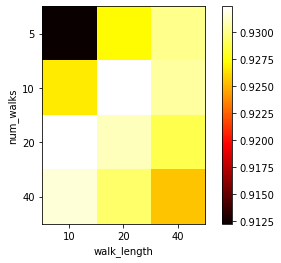

In [15]:
plt.figure(figsize=(6, 4))
node_dim = 10
# you should have an auc score dictionary here.
a = np.array([[deepwalk_auc_scores[(node_dim, num_walks, walk_length)] for walk_length in [10, 20, 40]] for num_walks in
              [5, 10, 20, 40]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0, 1, 2], labels=[10, 20, 40])
plt.xlabel("walk_length")
plt.yticks(ticks=[0, 1, 2, 3], labels=[5, 10, 20, 40])
plt.ylabel("num_walks")

You can build model with the best parameters you find and save the prediction here.

In [17]:
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=20)
scores = [get_cosine_sim(model, src, dst) for src, dst in test_edges]
write_pred("data/pred.csv", test_edges, scores)

building a DeepWalk model...	number of walks: 83430	average walk length: 19.7383	training time: 25.1332


In [19]:
import os

if not os.path.exists('for_weiqi'):
    os.mkdir('for_weiqi')
    
scores = [get_cosine_sim(model, src, dst) for src, dst in valid_edges]
write_pred('for_weiqi/valid_edges.csv', valid_edges, scores)

scores = [get_cosine_sim(model, src, dst) for src, dst in test_edges]
write_pred('for_weiqi/test_edges.csv', test_edges, scores)